In [17]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, KMeans
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

In [18]:
# infile = 'tess_ode.pkl'
infile = 'gaia2d_vecs.pkl'

In [19]:
data = pd.read_pickle(infile)

In [20]:
vecs = np.stack(list(data.values()))

In [21]:
vecs.shape

(1288, 40)

### DBSCAN

In [36]:
alg = DBSCAN(min_samples=5, n_jobs=-1)
# alg = OPTICS(min_samples=10, n_jobs=-1, cluster_method='dbscan')
# alg = AgglomerativeClustering(n_clusters=10)
# alg = KMeans(n_clusters=20)

In [37]:
clusters = alg.fit_predict(vecs)

In [38]:
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

### TSNE

In [39]:
tsne = TSNE(n_components=2, perplexity=30)

In [40]:
res = tsne.fit_transform(vecs)

In [41]:
pd.to_pickle(res, 'res.pkl')

### TSNE Post Clustering

In [42]:
res2 = pd.read_pickle('res.pkl')

In [43]:
# res2 = np.copy(res)
res2 = res2

In [44]:
x1s = res2[:,0]
x2s = res2[:,1]

In [45]:
x1s = (x1s-x1s.min())/(x1s.max()-x1s.min())
x2s = (x2s-x2s.min())/(x2s.max()-x2s.min())

In [46]:
res2[:,0] = x1s
res2[:,1] = x2s

In [47]:
# alg = DBSCAN(min_samples=50, n_jobs=-1, algorithm='ball_tree')
# alg = OPTICS(min_samples=50, metric='minkowski', p=2, cluster_method='xi')
# alg = KMeans(n_clusters=10)

In [ ]:
# clusters2 = alg.fit_predict(res2)

In [ ]:
# clusters2.max()

### Summary

In [ ]:
indir = 'tess/16_17/z_normalized/'
filenames = [indir+x+'.npy' for x in list(data.keys())]

In [48]:
# df = pd.DataFrame(zip(filenames, res2[:,0], res2[:,1], clusters),
#                   columns = ['file', 'x1', 'x2', 'cluster'])
df = pd.DataFrame(zip(res2[:,0], res2[:,1], clusters),
                  columns = ['x1', 'x2', 'cluster'])

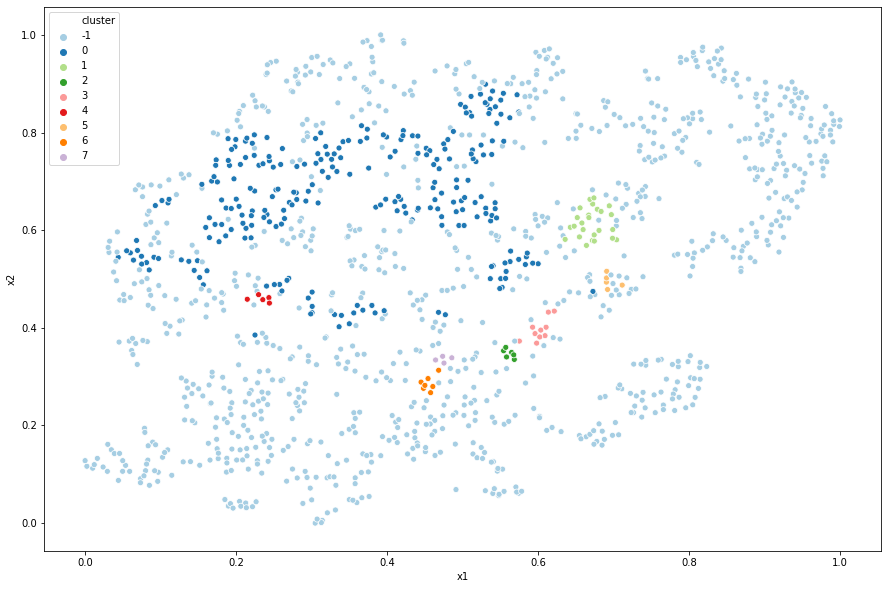

In [49]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='x1', y='x2', hue='cluster', data=df, 
                palette=sns.color_palette("Paired", df.cluster.nunique()))

### Random cluster view

In [ ]:
import random

In [ ]:
samples = dict(df.groupby('cluster')['file'].apply(lambda x: random.choice(list(x))))

In [ ]:
d = {}
for cluster, file in samples.items():
    entry = df.loc[df['file'] == file]
    x1 = entry['x1'].apply(lambda x: np.round(x,0)).values[0]
    x2 = entry['x2'].apply(lambda x: np.round(x,0)).values[0]
    outstr = str(cluster)+'_x1_'+str(x1)+'_x2_'+str(x2)
    d[cluster] = np.load(file)[1]

In [ ]:
f, axes = plt.subplots(len(np.unique(clusters)),1, figsize=(4, 25), sharey=True)
for i in range(len(d)):
    if i == 0:
        continue
    ax = axes[i-1]
    ax.set_xticks(ticks=[])
    ax.set_yticks(ticks=[])
#     ax.set_title('cluster: ' + str(ixs[i]) + '  ' + 'score: ' + str(probs[i]))
    sns.lineplot(x=np.arange(len(d[i])), y=d[i], color='b', ax=ax)